## Importing the dataset

In [1]:
import pandas as pd

# Load the training data from the CSV file
# Make sure the 'train.csv' file is in the same directory as your notebook,
# or provide the full path to the file.
try:
    df = pd.read_csv('train.csv')
except FileNotFoundError:
    print("Error: 'train.csv' not found. Please download it from Kaggle and place it in your project directory.")
    # You can stop here if the file isn't found
    # Or provide instructions on where to get it, e.g., link to Kaggle

# The dataset uses numbers for categories. Let's map them to their actual names.
# AG News Topic-to-ID mapping: 1->World, 2->Sports, 3->Business, 4->Sci/Tech
# We will use the names for clarity.
class_mapping = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
df['topic'] = df['Class Index'].map(class_mapping)

# Combine the 'Title' and 'Description' into a single 'text' column for analysis
df['text'] = df['Title'] + ' ' + df['Description']

# Select the columns we need and drop the rest
df = df[['text', 'topic']]

# Display the first few rows and the distribution of topics
print("Dataset loaded successfully. Here are the first 5 rows:")
print(df.head())
print("\nNumber of articles per topic:")
print(df['topic'].value_counts())


Dataset loaded successfully. Here are the first 5 rows:
                                                text     topic
0  Wall St. Bears Claw Back Into the Black (Reute...  Business
1  Carlyle Looks Toward Commercial Aerospace (Reu...  Business
2  Oil and Economy Cloud Stocks' Outlook (Reuters...  Business
3  Iraq Halts Oil Exports from Main Southern Pipe...  Business
4  Oil prices soar to all-time record, posing new...  Business

Number of articles per topic:
topic
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


## Text Cleaning and Preprocessing

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure NLTK data is downloaded (you likely did this in the last project)
# nltk.download('stopwords')
# nltk.download('wordnet')

# Initialize the lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Remove stopwords and perform lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join words back into a single string
    return ' '.join(words)

# Apply the cleaning function to the 'text' column
# This may take a few moments as it processes all 120,000 articles
print("Cleaning and preprocessing text... This may take a moment.")
df['cleaned_text'] = df['text'].apply(clean_text)
print("Text cleaning complete.")

# Display the original text and the cleaned version for comparison
print("\nOriginal vs. Cleaned Text:")
print(df[['text', 'cleaned_text']].head())


Cleaning and preprocessing text... This may take a moment.
Text cleaning complete.

Original vs. Cleaned Text:
                                                text  \
0  Wall St. Bears Claw Back Into the Black (Reute...   
1  Carlyle Looks Toward Commercial Aerospace (Reu...   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...   
3  Iraq Halts Oil Exports from Main Southern Pipe...   
4  Oil prices soar to all-time record, posing new...   

                                        cleaned_text  
0  wall st bear claw back black reuters reuters s...  
1  carlyle look toward commercial aerospace reute...  
2  oil economy cloud stock outlook reuters reuter...  
3  iraq halt oil export main southern pipeline re...  
4  oil price soar time record posing new menace u...  


## Feature Extraction with TF-IDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
# We'll limit the features to the 10,000 most frequent words to keep it manageable
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Define your features (X) and target (y)
print("Vectorizing text with TF-IDF...")
X = tfidf_vectorizer.fit_transform(df['cleaned_text'])
y = df['topic']
print("Vectorization complete.")

print("\nShape of the TF-IDF matrix:", X.shape)


Vectorizing text with TF-IDF...
Vectorization complete.

Shape of the TF-IDF matrix: (120000, 10000)


## Training and evaluating the model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Split the data into training and testing sets (80% train, 20% test)
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data split complete.")

# 2. Initialize and train the Logistic Regression model
# The 'multi_class' argument is handled automatically by scikit-learn
print("\nTraining the Logistic Regression model...")
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print("Model training complete.")

# 3. Make predictions on the test set
print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test)

# 4. Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Display the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Business', 'Sci/Tech', 'Sports', 'World']))



Splitting data into training and testing sets...
Data split complete.

Training the Logistic Regression model...
Model training complete.

Making predictions on the test set...

Model Accuracy: 0.9151

Classification Report:
              precision    recall  f1-score   support

    Business       0.88      0.89      0.88      6000
    Sci/Tech       0.89      0.89      0.89      6000
      Sports       0.96      0.98      0.97      6000
       World       0.93      0.91      0.92      6000

    accuracy                           0.92     24000
   macro avg       0.92      0.92      0.92     24000
weighted avg       0.92      0.92      0.92     24000



## Visualizing the Most Frequent Words

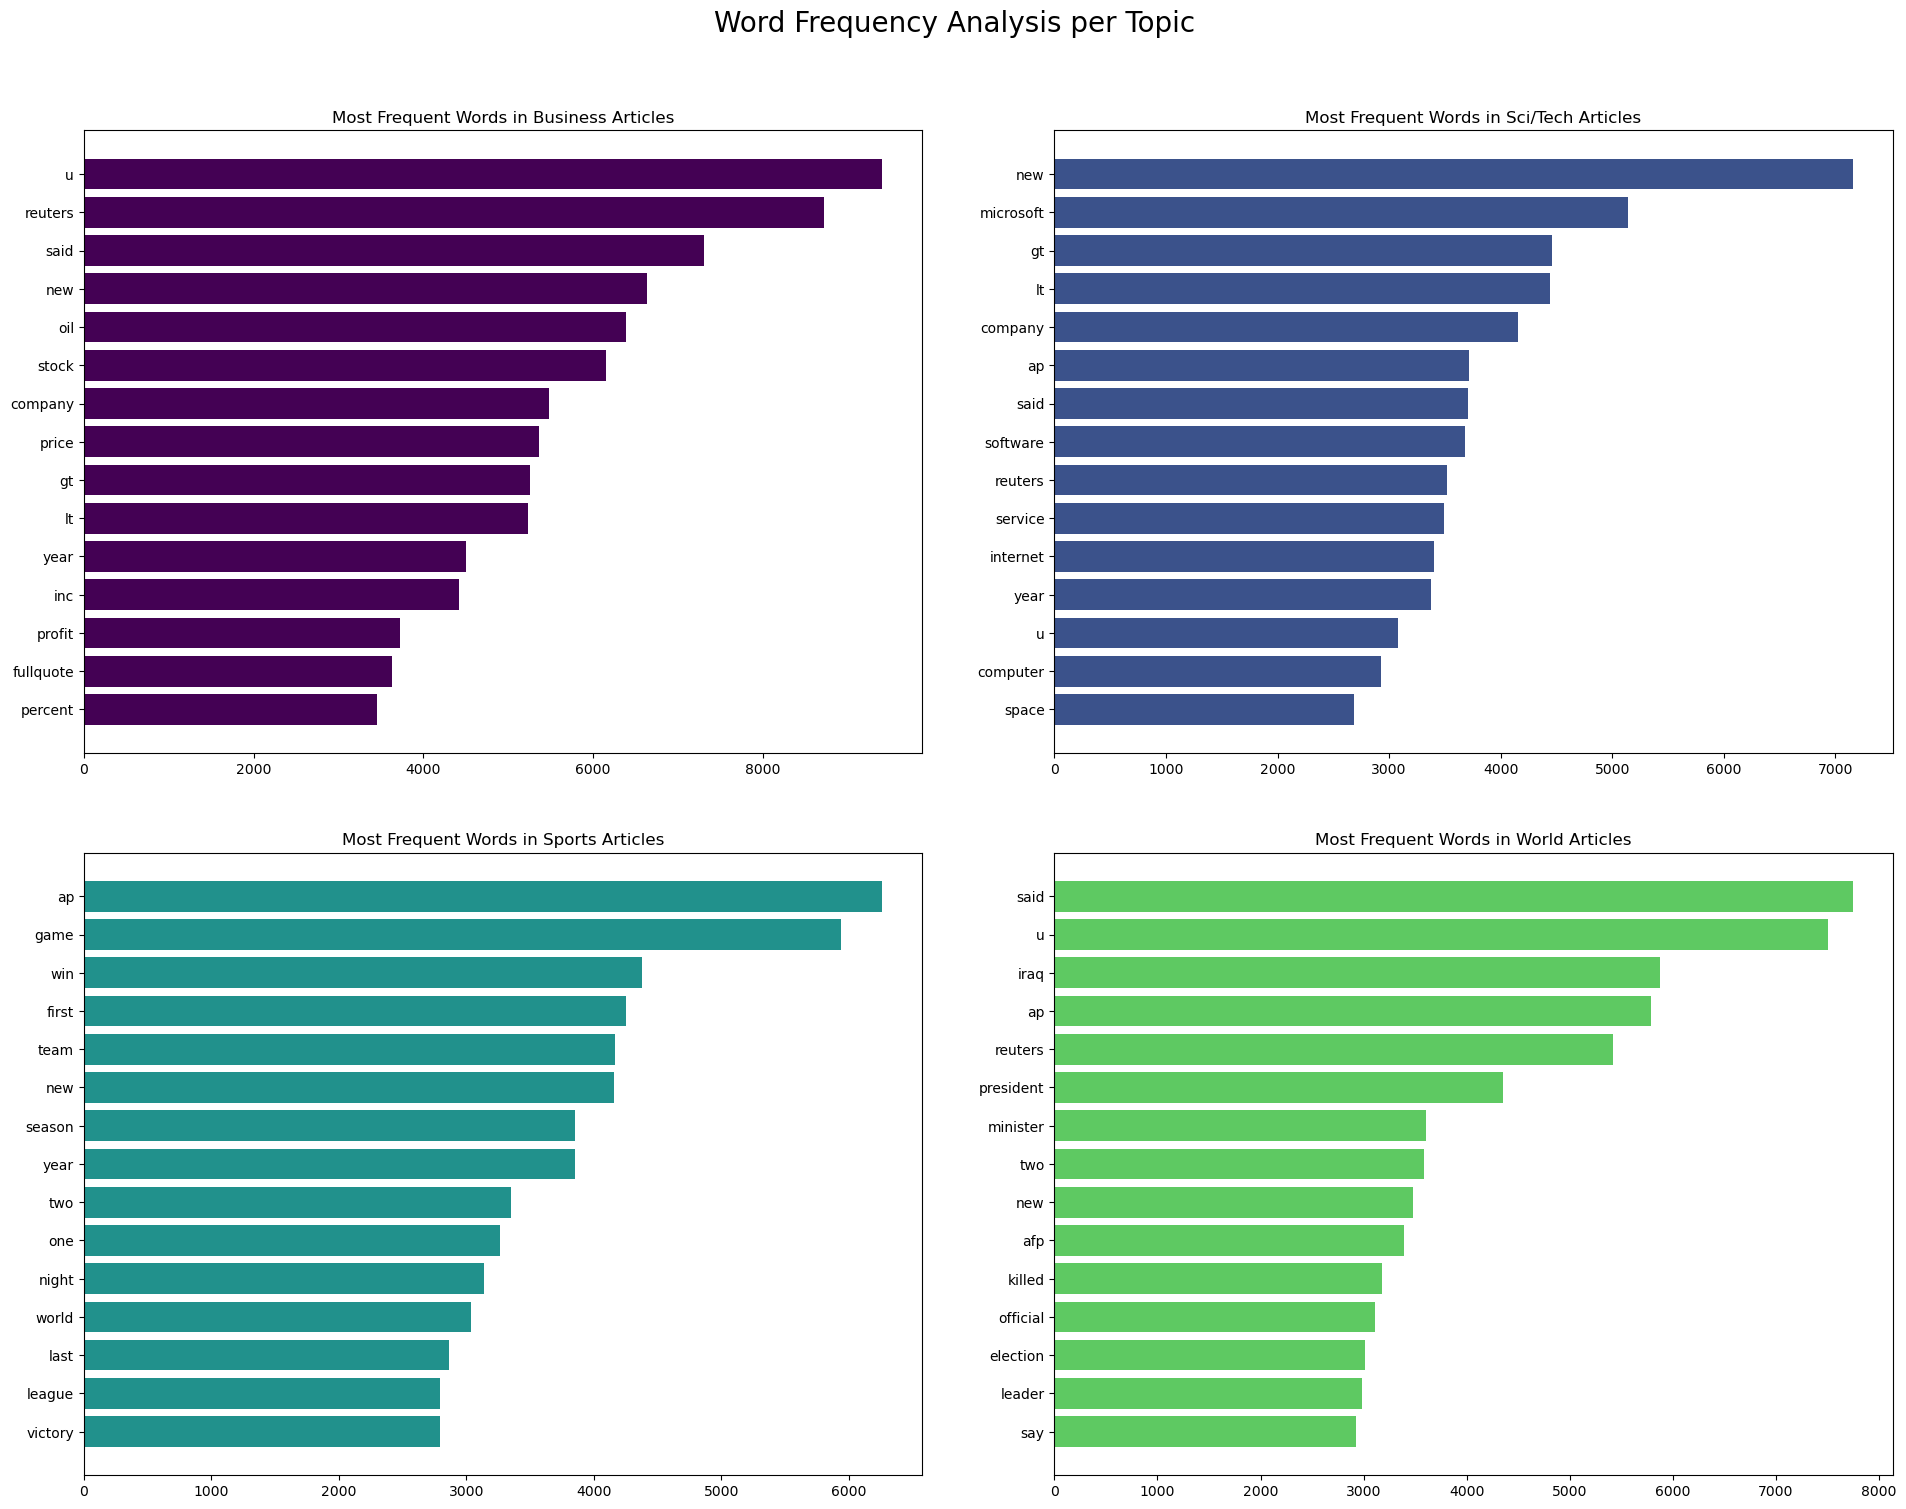

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# -- Ensure your 'df' DataFrame has the 'cleaned_text' and 'topic' columns --

# Get the list of unique topics
topics = df['topic'].unique()

# Create subplots for each topic
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten() # Flatten the 2x2 grid to a single list of axes

for i, topic in enumerate(topics):
    # Filter text for the current topic
    topic_text = ' '.join(df[df['topic'] == topic]['cleaned_text'])
    
    # Count word frequencies
    word_counts = Counter(topic_text.split())
    
    # Get the 15 most common words
    most_common_words = pd.DataFrame(word_counts.most_common(15), columns=['word', 'count'])
    
    # Plot the results
    ax = axes[i]
    ax.barh(most_common_words['word'], most_common_words['count'], color=plt.cm.viridis(i/len(topics)))
    ax.set_title(f'Most Frequent Words in {topic} Articles')
    ax.invert_yaxis()

plt.tight_layout(pad=4.0)
plt.suptitle('Word Frequency Analysis per Topic', fontsize=20, y=1.03)
plt.show()


## Testing the Model on New Headlines

In [6]:
# The vectorizer and model must be the ones you already trained
def predict_category(headline):
    # 1. Clean the new headline
    cleaned_headline = clean_text(headline)
    # 2. Transform using the TF-IDF vectorizer
    vectorized_headline = tfidf_vectorizer.transform([cleaned_headline])
    # 3. Predict using the trained model
    prediction = model.predict(vectorized_headline)
    
    return prediction[0]

# Example headlines
headline_1 = "Global markets react to new interest rate hike"
headline_2 = "Scientists discover new exoplanet with potential for liquid water"
headline_3 = "Local team wins championship in stunning overtime victory"

print(f"Headline: '{headline_1}'\nPredicted Category: {predict_category(headline_1)}\n")
print(f"Headline: '{headline_2}'\nPredicted Category: {predict_category(headline_2)}\n")
print(f"Headline: '{headline_3}'\nPredicted Category: {predict_category(headline_3)}\n")


Headline: 'Global markets react to new interest rate hike'
Predicted Category: Business

Headline: 'Scientists discover new exoplanet with potential for liquid water'
Predicted Category: Sci/Tech

Headline: 'Local team wins championship in stunning overtime victory'
Predicted Category: Sports

